In [1]:
from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

plt.style.use("seaborn")

# Loading data

In [2]:
data = load_digits()
print(list(data.keys()))

X = data["data"]
X = X.reshape(*X.shape, 1)

y = data["target"]
ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1, 1)).toarray().reshape(-1, 10, 1)

['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR']


In [3]:
print(X.shape)
print(y.shape)

(1797, 64, 1)
(1797, 10, 1)


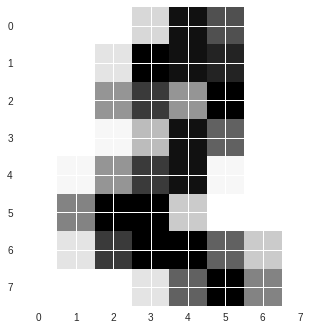

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [4]:
plt.imshow(X[2].reshape(8,8))
plt.show()

print(y[2])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Training

## custom net

In [6]:
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        train_acc_list = []
        test_acc_list = []
        
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in tqdm(range(epochs)):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            # updating metrics
            train_acc = self.evaluate(training_data) / n
            train_acc_list.append(train_acc)
            
            if test_data:
                test_acc = self.evaluate(test_data) / n_test
                test_acc_list.append(test_acc)
                
                #print("Epoch {0}: train: {1:.2f}; test: {2:.2f}".format(
                #    j, train_acc, test_acc))
            else:
                pass
                #print("Epoch {0}: train: {1:.2f}".format(j, train_acc))
                
        return train_acc_list, test_acc_list

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [7]:
training_data = [(x, y) for x, y in zip(X_train, y_train)]
test_data = [(x, y) for x, y in zip(X_test, y_test)]

In [8]:
net = Network([64, 16, 16, 10])
train, test = net.SGD(training_data=training_data, epochs=50, mini_batch_size=10, eta=1, test_data=test_data)

100%|██████████| 50/50 [00:04<00:00, 10.25it/s]


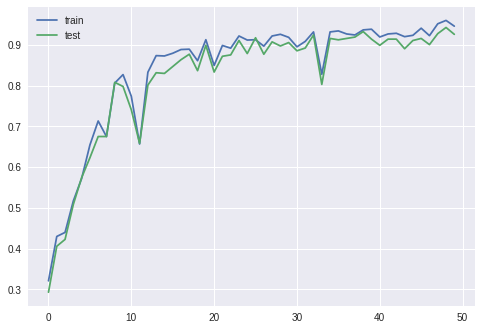

In [9]:
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.legend()
plt.show()

In [10]:
net.evaluate(test_data) / len(test_data)

0.9259259259259259

## pytorch